**Experiment**
**Predict next article**

Create the dataset by adding the next article bought by the customer, creating embeddings for articles by applying PCA to one hot encoded article features.

**Expected reason of low accuracy is the high variance in target variable as, only considering the first 100K transactions, there is around 14K unique values of next_article_id with almost half of them only occur once.**

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv', chunksize=100000, dtype=str)
articles = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv', dtype=str)
users = next(df)
users = users.merge(articles, on='article_id')

In [3]:
group_by_customer = users.groupby('customer_id')

**Create next_feature for every feature of each article for experimentation**

In [4]:
groups = []
for key in group_by_customer.groups.keys():
    group = group_by_customer.get_group(key).sort_values(by='t_dat')
    for column in group.columns:
        group['next_{}'.format(column)] = group[column].shift(-1)
        
    group = group.drop_duplicates(subset=['customer_id', 'article_id']).iloc[:-1]
    groups.append(group)

In [5]:
grouped_by_customers= pd.concat(groups)

In [6]:
grouped_by_customers.head()

t_dat                                        customer_id  \
7581   2018-09-21  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
20318  2018-09-21  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
0      2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
26     2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
37     2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   

       article_id                 price sales_channel_id product_code  \
7581   0640244003  0.033881355932203386                2      0640244   
20318  0583558001   0.06777966101694916                2      0583558   
0      0663713001  0.050830508474576264                2      0663713   
26     0505221004   0.01523728813559322                2      0505221   
37     0685687003  0.016932203389830508                2      0685687   

                      prod_name product_type_no product_type_name  \
7581            CORY CORD SKIRT             275             Skirt   
20318          Noel denim dress             265             Dress   
0      Atlanta Push Body Harlow             283    Underwear body   
26                  Inca Jumper             252           Sweater   
37         W YODA KNIT OL OFFER             252           Sweater   

       product_group_name  ... next_department_name next_index_code  \
7581   Garment Lower body  ...              Dresses               D   
20318   Garment Full body  ...               Blouse               A   
0               Underwear  ...      Casual Lingerie               B   
26     Garment Upper body  ...            Campaigns               A   
37     Garment Upper body  ...            Campaigns               A   

        next_index_name next_index_group_no next_index_group_name  \
7581            Divided                   2               Divided   
20318        Ladieswear                   1            Ladieswear   
0      Lingeries/Tights                   1            Ladieswear   
26           Ladieswear                   1            Ladieswear   
37           Ladieswear                   1            Ladieswear   

      next_section_no           next_section_name next_garment_group_no  \
7581               53          Divided Collection                  1013   
20318              15  Womens Everyday Collection                  1010   
0                  61             Womens Lingerie                  1017   
26                 15  Womens Everyday Collection                  1023   
37                 15  Womens Everyday Collection                  1023   

      next_garment_group_name  \
7581           Dresses Ladies   
20318                 Blouses   
0           Under-, Nightwear   
26             Special Offers   
37             Special Offers   

                                        next_detail_desc  
7581   Short, fitted dress in stretch denim with a co...  
20318  Shirt in a cotton weave with a collar, buttons...  
0      Lace push-up bras with underwired, moulded, pa...  
26     V-neck knitted jumper with long sleeves and ri...  
37     V-neck knitted jumper with long sleeves and ri...  

[5 rows x 58 columns]

In [7]:
grouped_by_customers.nunique()[['customer_id', 'article_id', 'next_article_id']]

customer_id        18725
article_id         11635
next_article_id    14330
dtype: int64

In [8]:
grouped_by_customers.to_csv('df_with_next_article.csv')

In [9]:
df = grouped_by_customers[['t_dat', 'customer_id', 'article_id', 'prod_name', 'product_type_name',
       'product_group_name', 
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name',
       'perceived_colour_master_name',
       'department_name', 'index_name',
       'index_group_name', 'section_name',
       'garment_group_name',
       'next_article_id']].reset_index().drop('index', axis=1)

In [10]:
df.head()

t_dat                                        customer_id  article_id  \
0  2018-09-21  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0640244003   
1  2018-09-21  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0583558001   
2  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0663713001   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...  0505221004   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...  0685687003   

                  prod_name product_type_name  product_group_name  \
0           CORY CORD SKIRT             Skirt  Garment Lower body   
1          Noel denim dress             Dress   Garment Full body   
2  Atlanta Push Body Harlow    Underwear body           Underwear   
3               Inca Jumper           Sweater  Garment Upper body   
4      W YODA KNIT OL OFFER           Sweater  Garment Upper body   

  graphical_appearance_name colour_group_name perceived_colour_value_name  \
0                     Solid             Black                        Dark   
1                     Denim              Blue                Medium Dusty   
2                     Solid             Black                        Dark   
3                   Melange              Pink                Medium Dusty   
4                   Melange              Pink                      Medium   

  perceived_colour_master_name      department_name        index_name  \
0                        Black               Skirts           Divided   
1                         Blue              Dresses           Divided   
2                        Black  Expressive Lingerie  Lingeries/Tights   
3                         Pink     Tops Knitwear DS           Divided   
4                         Pink            Campaigns        Ladieswear   

  index_group_name                section_name garment_group_name  \
0          Divided          Divided Collection             Skirts   
1          Divided          Divided Collection     Dresses Ladies   
2       Ladieswear             Womens Lingerie  Under-, Nightwear   
3          Divided            Divided Selected           Knitwear   
4       Ladieswear  Womens Everyday Collection     Special Offers   

  next_article_id  
0      0583558001  
1      0639677008  
2      0541518023  
3      0685687003  
4      0685687004

In [11]:
input_features = df[[
       'product_group_name', 
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name',
       'perceived_colour_master_name',
       'department_name', 'index_name',
       'index_group_name', 'section_name',
       'garment_group_name']]
dummies = pd.get_dummies(input_features)

In [12]:
n_components = 100
pca = PCA(n_components)
pca.fit(dummies)
pca.explained_variance_ratio_.sum()

0.9509003923740228

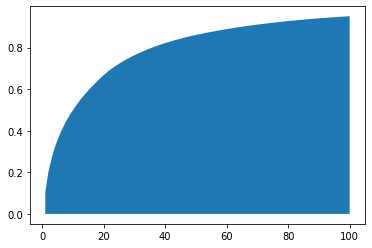

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
plt.fill_between(range(1, 101), exp_var_cumul)

In [15]:
features_pca = pca.transform(dummies)

In [16]:
from sklearn.preprocessing import LabelEncoder

target = df.next_article_id

le = LabelEncoder()
target = le.fit_transform(target)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.2, random_state=42)

In [18]:
tree = dtc()

tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [19]:
tree.score(x_train, y_train), tree.score(x_test, y_test)

(0.15616627425509458, 0.03994479175123813)